In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from ComputerVision.MaskedAutoEncoder.trainer.train_mae_v1 import MaskedAutoEncoder

Using device: cpu
Files already downloaded and verified
Files already downloaded and verified


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.manual_seed(1337)
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(0)
print(f"Using device: {device}", flush=True)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Using device: cpu
Files already downloaded and verified


In [11]:
# define the utils
cifar_mean = np.array([0.4914, 0.4822, 0.4465])
cifar_std = np.array([0.2470, 0.2435, 0.2616])

def show(img, ax=None, title=None):
    """Utility function to display an image"""
    if ax is None:
        ax = plt.gca()
    img = img.cpu().detach().numpy()
    if img.shape[0] == 1:  # Grayscale image
        img = img[0]
        ax.imshow(img, cmap='gray')
    elif img.shape[-1] == 3:  # Already HWC
        img = img * cifar_std + cifar_mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
    else:  # CHW
        img = img.transpose((1, 2, 0))  # Convert to HWC
        img = img * cifar_std + cifar_mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

def prepare_model(checkpoint):
    mae_model = MaskedAutoEncoder(
        embed_size=128,
        decoder_embed_size=64, num_patches=256,
        forward_expansion=256, dropout=0.1, num_attention_heads=8,
        qvk_bias=True, dataset=test_dataset, patch_size=2,
        encod_hidden_layers=8, decod_hidden_layers=4,
        num_channels=3
    )
    # load model
    checkpoint = torch.load(checkpoint, map_location='cpu')
    mae_model.load_state_dict(checkpoint['model_state_dict'])
    mae_model.eval()
    return mae_model

def run_one_image(x, model):
    # make it a batch-like
    x = x.unsqueeze(dim=0)
    #x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show(x[0], title="original")

    plt.subplot(1, 4, 2)
    show(im_masked[0],title= "masked")

    plt.subplot(1, 4, 3)
    show(y[0], title="reconstruction")

    plt.subplot(1, 4, 4)
    show(im_paste[0],title= "reconstruction + visible")

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1589322..1.9320949].


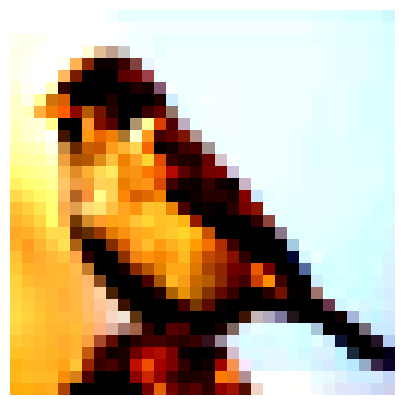

In [15]:
# load an image
img_1, _ = test_dataset[np.random.randint(len(test_dataset))]  # Get the first test image

plt.rcParams['figure.figsize'] = [5, 5]
show(img_1)

In [ ]:
checkpoint = 'checkpoint.pth'
model_mae = prepare_model(checkpoint)
print('Model loaded.')

In [ ]:
# make random mask reproducible (comment out to make it change)
print('MAE with pixel reconstruction:')
run_one_image(img_1, model_mae)

In [ ]:
print('MAE with pixel reconstruction:')
img_2, _ = test_dataset[1]  # Get the first test image
img_1 = img_1.unsqueeze(0).to(device)  # Add batch dimension
run_one_image(img_2, model_mae)

In [ ]:
print('MAE with pixel reconstruction:')
img_3, _ = test_dataset[2]  # Get the first test image
img_3 = img_3.unsqueeze(0).to(device)  # Add batch dimension
run_one_image(img_3, model_mae)

In [ ]:
print('MAE with pixel reconstruction:')
img_4, _ = test_dataset[3]  # Get the first test image
img_4 = img_4.unsqueeze(0).to(device)  # Add batch dimension
run_one_image(img_4, model_mae)